# Sornette's Log Periodic Power Law Singularity Model

An entirely cannonical implementation of the LPPLS model of bubbles in financial markets and other complex adaptive systems. Largely following the excellent dissertation Information Geometry and the Dynamic Detection of Financial Bubbles & Crashes - Demos [2017].

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy import linalg
import yfinance as yf
import random
import matplotlib.pyplot as plt
import timeit

In [2]:
spy = yf.download('SPY', period='max')

[*********************100%***********************]  1 of 1 completed


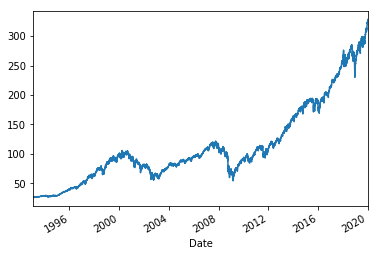

In [4]:
%matplotlib inline
spy['Adj Close'].plot()

In [5]:
df = spy.loc['2003-01-01':'2009-01-01', 'Adj Close']

In [6]:
class LPPL:
    
    def __init__(self, timeseries):
        self.data = np.array(timeseries)
        self.ordinal = np.array(range(len(timeseries)))
        self.n = len(self.ordinal)
        
    def lppl(self, tc, m, w, a, b, c1, c2):
        return a + np.power(tc - self.ordinal, m) * (b + ((c1 * np.cos(w * np.log(tc - self.ordinal))) + (c2 * np.sin(w * np.log(tc - self.ordinal)))))
    
    
    def linear(self, tc, m, w):
        
        # helper functions
        def _y(): return np.log(self.data)
        def _f(): return np.power(tc - self.ordinal, m)
        def _g(): return np.power(tc - self.ordinal, m) * np.cos(w * np.log(tc - self.ordinal))
        def _h(): return np.power(tc - self.ordinal, m) * np.sin(w * np.log(tc - self.ordinal))
        
        n = self.n
        y = np.sum(_y())
        f = np.sum(_f())
        g = np.sum(_g())
        h = np.sum(_h())
        ff = np.sum(_f() ** 2)
        fg = np.sum(_f() * _g())
        fh = np.sum(_f() * _h())
        gg = np.sum(_g() * _g())
        gh = np.sum(_g() * _h())
        hh = np.sum(_h() * _h())
        yf = np.sum(_y() * _f())
        yg = np.sum(_y() * _g())
        yh = np.sum(_y() * _h())
        
        matrix = np.array([
            [n, f , g , h ],
            [f, ff, fg, fh],
            [g, fg, gg, gh],
            [h, fh, gh, hh]       
        ])
        
        vector = np.array([
            [y],
            [yf],
            [yg],
            [yh]
        ])
        
        """
        #diagnostics
        print('########## my imp ############')
        print('ordinal: ', self.ordinal)
        print('data: ', self.data)
        print('n: ', self.n)
        print('f: ', f)
        print('g: ', g)
        print('h: ', h)
        print('ff: ', ff)
        print('gg: ', gg)
        print('hh: ', hh)
        print('fg: ', fg)
        print('fh: ', fh)
        print('gh: ', gh)
        print('y: ', y)
        print('yf: ', yf)
        print('yg: ', yg)
        print('yh: ', yh)
        """
        
        product = linalg.solve(matrix, vector) 
        return [i[0] for i in product]
        
        
    def func(self, x):
        tc = x[0]
        m = x[1]
        w = x[2]
        
        lins = self.linear(tc, m, w)
        a, b, c1, c2 = lins[0], lins[1], lins[2], lins[3]
        
        delta = np.sum((self.lppl(tc, m, w, a, b, c1, c2) - self.data) ** 2)
        return delta
    
    
    def func_restricted(self, x):
        tc = x[0]
        m  = x[1]
        w  = x[2]

        lin_vals = self.linear(tc, m, w)

        a  = lin_vals[0] 
        b  = lin_vals[1]
        c1 = lin_vals[2] 
        c2 = lin_vals[3]

        delta = self.lppl(tc, m, w, a, b, c1, c2)
        delta = np.subtract(delta, self.data)
        delta = np.power(delta, 2)
        return np.sum(delta)
    
    
    def solve(self):
        
        bounds = np.array([
            (self.n + 1, self.n * 1.5),
            (0.1, 0.9),
            (6, 13)
        ])
        
        bounds2 = (
                [self.n + 1, 0.1, 6],
                [self.n * 1.5, 0.9, 13]
        )
        
        non_lins = [random.uniform(a[0], a[1]) for a in bounds]
        tc = non_lins[0]
        m = non_lins[1]
        w = non_lins[2]
        seed = np.array([tc, m, w])
        print('Seed: ', seed)
        
        print('Minimizing')
        
        cofs = minimize(fun=self.func,
                        method='SLSQP',
                        x0=seed,
                        bounds=bounds,
                        options={'disp':1}
                      )
        """
        cofs = scipy.optimize.least_squares(
                        fun=self.func,
                        x0=seed,
                        jac='2-point',
                        bounds=bounds2,
                        x_scale='jac'        
                    )
       
        print('Minimized')
        """
        tc = cofs.x[0]
        m = cofs.x[1]
        w = cofs.x[2]
        
        lins = self.linear(tc, m, w)
        a = lins[0]
        b = lins[1]
        c1 = lins[2]
        c2 = lins[3]
        
        parameters = [tc, m, w, a, b, c1, c2]
        return parameters

In [7]:
class LPPL_T1:
    
    # LPPL with the t1 bubble start value endogenized as a parameter
    # as opposed to being the first date in the time series inexorably 
    
    
    def __init__(self, timeseries):
        self.data = np.array(timeseries)
        self.ordinal = np.array(range(len(timeseries)))
        self.n = len(self.ordinal)
        
    def lppl(self, tc, m, w, a, b, c1, c2):
        return a + np.power(tc - self.ordinal, m) * (b + ((c1 * np.cos(w * np.log(tc - self.ordinal))) + (c2 * np.sin(w * np.log(tc - self.ordinal)))))
    
    
    def linear(self, tc, m, w):
        
        # helper functions
        def _y(): return np.log(self.data)
        def _f(): return np.power(tc - self.ordinal, m)
        def _g(): return np.power(tc - self.ordinal, m) * np.cos(w * np.log(tc - self.ordinal))
        def _h(): return np.power(tc - self.ordinal, m) * np.sin(w * np.log(tc - self.ordinal))
        
        n = self.n
        y = np.sum(_y())
        f = np.sum(_f())
        g = np.sum(_g())
        h = np.sum(_h())
        ff = np.sum(_f() ** 2)
        fg = np.sum(_f() * _g())
        fh = np.sum(_f() * _h())
        gg = np.sum(_g() * _g())
        gh = np.sum(_g() * _h())
        hh = np.sum(_h() * _h())
        yf = np.sum(_y() * _f())
        yg = np.sum(_y() * _g())
        yh = np.sum(_y() * _h())
        
        matrix = np.array([
            [n, f , g , h ],
            [f, ff, fg, fh],
            [g, fg, gg, gh],
            [h, fh, gh, hh]       
        ])
        
        vector = np.array([
            [y],
            [yf],
            [yg],
            [yh]
        ])
        
        """
        print('########## my imp ############')
        print('ordinal: ', self.ordinal)
        print('data: ', self.data)
        print('n: ', self.n)
        print('f: ', f)
        print('g: ', g)
        print('h: ', h)
        print('ff: ', ff)
        print('gg: ', gg)
        print('hh: ', hh)
        print('fg: ', fg)
        print('fh: ', fh)
        print('gh: ', gh)
        print('y: ', y)
        print('yf: ', yf)
        print('yg: ', yg)
        print('yh: ', yh)
        """
        
        product = linalg.solve(matrix, vector) 
        return [i[0] for i in product]
        
        
    def func(self, x):
        tc = x[0]
        m = x[1]
        w = x[2]
        
        lins = self.linear(tc, m, w)
        a, b, c1, c2 = lins[0], lins[1], lins[2], lins[3]
        
        delta = np.sum((self.lppl(tc, m, w, a, b, c1, c2) - self.data) ** 2)
        return delta
    
    
    def func_restricted(self, x):
        tc = x[0]
        m  = x[1]
        w  = x[2]

        lin_vals = self.linear(tc, m, w)

        a  = lin_vals[0] 
        b  = lin_vals[1]
        c1 = lin_vals[2] 
        c2 = lin_vals[3]

        delta = self.lppl(tc, m, w, a, b, c1, c2)
        delta = np.subtract(delta, self.data)
        delta = np.power(delta, 2)
        return np.sum(delta)
    
    
    def solve(self):
        
        bounds = np.array([
            (self.n + 1, self.n * 1.5),
            (0.1, 0.9),
            (6, 13)
        ])
        
        bounds2 = (
                [self.n + 1, 0.1, 6],
                [self.n * 1.5, 0.9, 13]
        )
        
        non_lins = [random.uniform(a[0], a[1]) for a in bounds]
        tc = non_lins[0]
        m = non_lins[1]
        w = non_lins[2]
        seed = np.array([tc, m, w])
        print('Seed: ', seed)
        
        print('Minimizing')
        
        cofs = minimize(fun=self.func,
                        method='SLSQP',
                        x0=seed,
                        bounds=bounds,
                        options={'disp':1}
                      )
        """
        cofs = scipy.optimize.least_squares(
                        fun=self.func,
                        x0=seed,
                        jac='2-point',
                        bounds=bounds2,
                        x_scale='jac'        
                    )
       
        print('Minimized')
        """
        tc = cofs.x[0]
        m = cofs.x[1]
        w = cofs.x[2]
        
        lins = self.linear(tc, m, w)
        a = lins[0]
        b = lins[1]
        c1 = lins[2]
        c2 = lins[3]
        
        parameters = [tc, m, w, a, b, c1, c2]
        return parameters

In [119]:
class LPPL_testing:
    
    # was used to insert parts of code from github implementation for cross-checking units 
    
    def __init__(self, timeseries):
        self.data = np.array(timeseries)
        self.ordinal = np.array(range(len(timeseries)))
        self.n = len(self.ordinal)
        
    def lppl(self, tc, m, w, a, b, c1, c2):
        return a + np.power(tc - self.ordinal, m) * (b + ((c1 * np.cos(w * np.log(tc - self.ordinal))) + (c2 * np.sin(w * np.log(tc - self.ordinal)))))
    
    
    def linear(self, tc, m, w):
        
        # helper functions
        def _y(): return np.log(self.data)
        def _f(): return np.power(tc - self.ordinal, m)
        def _g(): return np.power(tc - self.ordinal, m) * np.cos(w * np.log(tc - self.ordinal))
        def _h(): return np.power(tc - self.ordinal, m) * np.sin(w * np.log(tc - self.ordinal))
        
        n = self.n
        y = np.sum(_y())
        f = np.sum(_f())
        g = np.sum(_g())
        h = np.sum(_h())
        ff = np.sum(_f() ** 2)
        fg = np.sum(_f() * _g())
        fh = np.sum(_f() * _h())
        gg = np.sum(_g() * _g())
        gh = np.sum(_g() * _h())
        hh = np.sum(_h() * _h())
        yf = np.sum(_y() * _f())
        yg = np.sum(_y() * _g())
        yh = np.sum(_y() * _h())
        
        matrix = np.array([
            [n, f , g , h ],
            [f, ff, fg, fh],
            [g, fg, gg, gh],
            [h, fh, gh, hh]       
        ])
        
        vector = np.array([
            [y],
            [yf],
            [yg],
            [yh]
        ])
        
        """
        print('########## my imp ############')
        print('ordinal: ', self.ordinal)
        print('data: ', self.data)
        print('n: ', self.n)
        print('f: ', f)
        print('g: ', g)
        print('h: ', h)
        print('ff: ', ff)
        print('gg: ', gg)
        print('hh: ', hh)
        print('fg: ', fg)
        print('fh: ', fh)
        print('gh: ', gh)
        print('y: ', y)
        print('yf: ', yf)
        print('yg: ', yg)
        print('yh: ', yh)
        """
        
        product = linalg.solve(matrix, vector) 
        return [i[0] for i in product]
        
        
    def func(self, x):
        tc = x[0]
        m = x[1]
        w = x[2]
        
        lins = self.linear(tc, m, w)
        a, b, c1, c2 = lins[0], lins[1], lins[2], lins[3]
        
        delta = np.sum((self.lppl(tc, m, w, a, b, c1, c2) - self.data) ** 2)
        return delta
    
    
    def func_restricted(self, x):
        tc = x[0]
        m  = x[1]
        w  = x[2]

        lin_vals = self.linear(tc, m, w)

        a  = lin_vals[0] 
        b  = lin_vals[1]
        c1 = lin_vals[2] 
        c2 = lin_vals[3]

        delta = self.lppl(tc, m, w, a, b, c1, c2)
        delta = np.subtract(delta, self.data)
        delta = np.power(delta, 2)
        return np.sum(delta)
    
    
    def solve(self):
        
        found_solution = False
        solution_count = 0
        solutions = []

        while not found_solution:
            print("Running {}".format(solution_count))

            # set limits for non-linear params
            limits = (
                [self.n-(self.n*0.2), self.n+(self.n*0.2)],    # Critical Time + or - .2
                [0.1, 0.9],                            # m : 0.1 ≤ m ≤ 0.9
                [6, 13],                               # ω : 6 ≤ ω ≤ 13     
            )

            # randomly choose vals for non-linear params 
            non_lin_vals = [random.uniform(a[0], a[1]) for a in limits]

            tc = non_lin_vals[0]
            m  = non_lin_vals[1] 
            w  = non_lin_vals[2]

            # params to pass to scipy.optimize
            seed = [tc, m, w]

            try:
                cofs = minimize(fun=self.func, 
                                x0=seed, 
                                bounds=limits,
                                method='Nelder-Mead')

                if cofs.success:
                    print(cofs)
                    solutions.append({
                        'fit': func_restricted(cofs.x),
                        'cof': cofs.x
                    })
                    found_solution = True
                else:
                    solution_count = solution_count + 1

                print("Success: {}\nMessage: {}".format(cofs.success, cofs.message))
                print("Number of iterations: {}".format(cofs.nit))
                print("Number of evaluations of obj funcs: {}".format(cofs.nfev))
                print("-"*25)
            except Exception as e:
                print("Exception: {}".format(e))
                print(non_lin_vals)
                print(self.linear(non_lin_vals[0], non_lin_vals[1], non_lin_vals[2]))
                solution_count = solution_count + 1

In [11]:
lppl = LPPL(df[:'2007-01-01'])
solution = lppl.solve()
tc = solution[0]
m = solution[1]
w = solution[2]
a = solution[3]
b = solution[4]
c1 = solution[5]
c2 = solution[6]

Seed:  [1.16128500e+03 8.70605595e-01 8.12910530e+00]
Minimizing
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6759756.619509611
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3


In [12]:
print(solution)

[1161.243874994496, 0.9, 8.18990774858473, 4.757840632751288, -0.0009312864726933474, -2.4351086191936276e-05, -0.00011527501347647033]


In [13]:
lppl.func([tc, m, w])

6759756.619509611

In [14]:
lppl.func_restricted([tc, m, w])

6759756.619509611

In [15]:
lppl_fit = lppl.lppl(tc, m, w, a, b, c1, c2)
lppl_fit = pd.Series(lppl_fit, index=df[:'2007-01-01'].index)

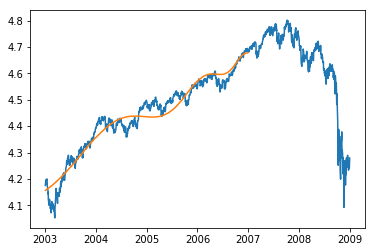

In [20]:
fig, ax = plt.subplots()

ax.plot(np.log(df))
ax.plot(lppl_fit)

In [21]:
lf = LPPL(df[:'2009-01-01'])
lf_d = lf.lppl(tc, m, w, a, b, c1, c2)

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


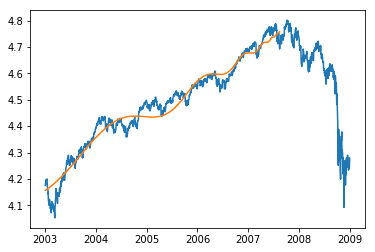

In [22]:
fig, ax = plt.subplots()
ax.plot(np.log(df))
ax.plot(pd.Series(lf_d, index=df[:'2009-01-01'].index))

In [20]:
l = len(df[:'2007-01-01'])

tc = l * 1.33
m = 0.5
w = 9

lppl = LPPL(df[:'2007-01-01']) # my matrix equations/helper functions
lppl_testing = LPPL_testing(df[:'2007-01-01']) # from github

lin = lppl.linear(tc, m, w)
lin_testing = lppl_testing.linear(tc, m, w)

print('my linear variables: ', lin)
print('github matrix eq. linear variables: ', lin_testing)


my linear variables:  [1.650081157068124, -0.005623140220910657, 0.00014529143805863475, -0.0002617383233847254]
github matrix eq. linear variables:  [1.6500811570678242, -0.0056231402208999914, 0.00014529143805768442, -0.00026173832338550974]


In [27]:
l = len(df[:'2007-01-01'])

tc = l * 1.33
m = 0.5
w = 9

lppl = LPPL(df[:'2007-01-01']) # my matrix equations/helper functions
lppl_testing = LPPL_testing(df[:'2007-01-01']) # from github

lin = lppl.linear(tc, m, w)
lin_testing = lppl_testing.linear(tc, m, w)


a = lin[0]
b = lin[1]
c1 = lin[2]
c2 = lin[3]

at = lin_testing[0]
bt = lin_testing[1]
c1t = lin_testing[2]
c2t = lin_testing[3]

lppl_results = lppl.lppl(tc, m, w, a, b, c1, c2)
lppl_t_results = [lppl_testing.lppl(t, tc, m, w, a, b, c1, c2) for t in np.array(range(len(df[:'2007-01-01'])))]

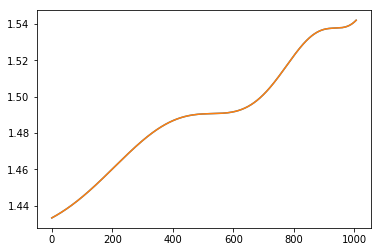

In [32]:
fig, ax = plt.subplots()

ax.plot(lppl_results)
ax.plot(lppl_t_results)

In [ ]:
l = len(df[:'2007-01-01'])

tc = l * 1.33
m = 0.5
w = 9

lppl = LPPL(df[:'2007-01-01']) # my matrix equations/helper functions
lppl_testing = LPPL_testing(df[:'2007-01-01']) # from github

delta = lppl.func(tc, m, w)
delta_t = [lppl(t, tc, m, w, a, b, c1, c2) for t in data_series[0]]
delta_t = np.subtract(delta, data_series[1])
delta_t = np.power(delta, 2)


print('delta: ', delta)
print('delta_Test: ', delta_testing)